In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [65]:
data_train = pd.read_csv('../finance_dataset/train.csv')

In [66]:
data_test = pd.read_csv('../finance_dataset/testA.csv')

In [67]:
print(data_test.shape)
print(data_train.shape)

(200000, 46)
(800000, 47)


填充缺失值

In [68]:
# employmentLength为类别型变量，使用前填充，
data_train.fillna(method='ffill',inplace=True)
data_test.fillna(method='ffill',inplace=True)

In [69]:
# 验证，已经没有缺失值
data_test.isnull().sum()

id                    0
loanAmnt              0
term                  0
interestRate          0
installment           0
grade                 0
subGrade              0
employmentTitle       0
employmentLength      0
homeOwnership         0
annualIncome          0
verificationStatus    0
issueDate             0
purpose               0
postCode              0
regionCode            0
dti                   0
delinquency_2years    0
ficoRangeLow          0
ficoRangeHigh         0
openAcc               0
pubRec                0
pubRecBankruptcies    0
revolBal              0
revolUtil             0
totalAcc              0
initialListStatus     0
applicationType       0
earliesCreditLine     0
title                 0
policyCode            0
n0                    0
n1                    0
n2                    0
n3                    0
n4                    0
n5                    0
n6                    0
n7                    0
n8                    0
n9                    0
n10             

### 时间格式处理

In [70]:
# issueDateDT得到的是天数
for data in [data_train,data_test]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01','%Y-%m-%d')
    data['issueDateDT'] = data['issueDate'].apply(lambda x:x-startdate).dt.days

In [20]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueDateDT'],
      dtype='object')

In [28]:
# 2007-06-01是最小日期
data.loc[data_train['issueDateDT']<=0,'issueDate']

647313   2007-06-01
Name: issueDate, dtype: datetime64[ns]

In [71]:
# earliesCreditLine为类别型数据，但是，类别太多，取出earliesCreditLine年份
for data in [data_train,data_test]:
    data['earliesCreditLine_year'] = data['earliesCreditLine'].apply(lambda x:int(x[-4:]))
    

In [73]:
# sort_index按照索引排序
data_test['employmentLength'].value_counts().sort_index()

1 year       14017
10+ years    69874
2 years      19347
3 years      17012
4 years      12566
5 years      13324
6 years       9898
7 years       9304
8 years       9595
9 years       8073
< 1 year     16990
Name: employmentLength, dtype: int64

### 数据特征

In [74]:
object_data=data_train.select_dtypes(include='object')
object_data.columns

Index(['grade', 'subGrade', 'employmentLength', 'earliesCreditLine'], dtype='object')

In [75]:
numeraic_data=data_train.select_dtypes(exclude='object')
numeraic_data.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment',
       'employmentTitle', 'homeOwnership', 'annualIncome',
       'verificationStatus', 'issueDate', 'isDefault', 'purpose', 'postCode',
       'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow',
       'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal',
       'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType',
       'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7',
       'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueDateDT',
       'earliesCreditLine_year'],
      dtype='object')

In [76]:
# num_data
def get_num_obj_data(data,feas):
    num_obj_data_columns = []
    for fea in feas:
        num = data[fea].nunique()

        if num<20:
            num_obj_data_columns.append(fea)
    return num_obj_data_columns
num_obj_col = get_num_obj_data(data_train,numeraic_data.columns)

In [77]:
num_obj_col

['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'purpose',
 'pubRecBankruptcies',
 'initialListStatus',
 'applicationType',
 'policyCode',
 'n11',
 'n12']

In [78]:
data_train['regionCode'].unique()

array([32, 18, 14, 11, 21,  4, 13,  8, 49, 38, 36, 15, 43,  7, 48,  9, 10,
       30, 26, 37, 17, 33, 23,  3, 20,  0,  2, 28, 22, 39, 19, 16,  5, 35,
       42, 45,  6, 12, 44, 24, 27, 31, 25, 40, 41,  1, 46, 34, 47, 29, 50],
      dtype=int64)

In [79]:
num_nobj_col = [col for col in numeraic_data.columns if col not in num_obj_col]
num_nobj_col

['id',
 'loanAmnt',
 'interestRate',
 'installment',
 'employmentTitle',
 'annualIncome',
 'issueDate',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'title',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14',
 'issueDateDT',
 'earliesCreditLine_year']

以上共有3类特征，字符类型的类别特征，数值类型的类别特征，数值型的连续数据
以下对类别特征和连续数据进行处理和分析

### 对象类型特征转换到数值

去掉只有一个值的特征policyCode
isDafault是标签变量
issueDate已经被转化为了天数
earliesCreditLine为类别型数据，转化为天数
grade有优先级，需要进行标签编码，而不是onehot编
employmentLength 将年份提取出来

In [32]:
['grade', 'subGrade', 'employmentLength', 'issueDate','earliesCreditLine']+['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'purpose',
 'pubRecBankruptcies',
 'initialListStatus',
 'applicationType',
 'policyCode',
 'n11',
 'n12']

#### 对字符类型的类别特征处理

In [80]:
# grade
# 因为grade有优先级，亦等级，所以要标签编码
dict_grade = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}
for data in [data_train,data_test]:
    data['grade_label2code'] = data['grade'].map(dict_grade)

In [81]:
# 对employmentLength_to_int进行处理，然后只用年份来表示数据
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return int(s.split()[0])
for data in [data_train,data_test]:
    data['employmentLength'].replace('10+ years','10 years',inplace=True)
    data['employmentLength'].replace('< 1 year','0 years',inplace=True)
    data['employmentLength_label2code']=data['employmentLength'].apply(employmentLength_to_int)

In [82]:
dict_sgrade=data_train['subGrade'].unique()
dict_sgrade=sorted(dict_sgrade)
dict_sgrade = {dict_sgrade[i]:i for i in range(len(dict_sgrade))}
for data in [data_train,data_test]:
    data['subGrade_label2code'] = data['subGrade'].map(dict_sgrade)

In [83]:
print(data_test.shape)
print(data_train.shape)

(200000, 51)
(800000, 52)


年份是one-hot编码还是label_encode比较好

In [86]:
cate_feature = num_obj_col.remove('isDefault')

In [90]:
data_train = pd.get_dummies(data_train,columns=cate_feature,drop_first=True)
# data_test = pd.get_dummies(data_test,columns=cate_feature,drop_first=True)

In [95]:
num_obj_col

['term',
 'homeOwnership',
 'verificationStatus',
 'purpose',
 'pubRecBankruptcies',
 'initialListStatus',
 'applicationType',
 'policyCode',
 'n11',
 'n12']

In [100]:
data_train.columns[:90]

Index(['id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle',
       'annualIncome', 'issueDate', 'postCode', 'regionCode', 'dti',
       'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc',
       'pubRec', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1',
       'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14',
       'issueDateDT', 'earliesCreditLine_year', 'grade_label2code',
       'employmentLength_label2code', 'subGrade_label2code', 'term_5',
       'homeOwnership_1', 'homeOwnership_2', 'homeOwnership_3',
       'homeOwnership_4', 'homeOwnership_5', 'verificationStatus_1',
       'verificationStatus_2', 'isDefault_1', 'purpose_1', 'purpose_2',
       'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7',
       'purpose_8', 'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12',
       'purpose_13', 'pubRecBankruptcies_1.0', 'pubRecBankruptcies_2.0',
       'pubRecBankruptcies_3.0', 'pubRecBankruptcies_4.0',
       'p

In [93]:
data_test.shape

(200000, 764)

In [75]:
# 由此可见，都转化为了数值类型
data_train_cated.select_dtypes(exclude='object').shape

(800000, 113)

In [27]:
data_train_cated=data_train.copy()

## 异常值处理

3segma做

In [28]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [29]:
numerical_fea=['id',
 'loanAmnt',
 'interestRate',
 'installment',
 'employmentTitle',
 'annualIncome',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'title',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14']

In [30]:
data_train['isDefault'].value_counts()

0    640390
1    159610
Name: isDefault, dtype: int64

这个也看不出来史啥意思

In [86]:
data_train = data_train_cated.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print('mmmmmmmmmmmmmmmmmmmmm')
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

正常值    800000
Name: id_outliers, dtype: int64
mmmmmmmmmmmmmmmmmmmmm
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: loanAmnt_outliers, dtype: int64
mmmmmmmmmmmmmmmmmmmmm
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
mmmmmmmmmmmmmmmmmmmmm
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
mmmmmmmmmmmmmmmmmmmmm
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
mmmmmmmmmmmmmmmmmmmmm
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      6027
Name: annualIncome_outliers, dtype: int64
mmmmmmmmmmmmmmmmmmmmm
annualIncome_outliers
异常值       756
正常值    158854
Name: isDefault, dtype: int64
**********
正常值    798

### 分箱

#### 固定宽度分箱

In [31]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000,只取整，不要余数
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)

In [88]:
## 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data_train['loanAmnt']))

In [90]:
data['loanAmnt_bin2'].value_counts()

4.0    528623
3.0    271370
2.0         7
Name: loanAmnt_bin2, dtype: int64

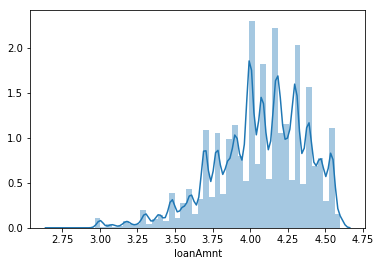

In [93]:
sns.distplot(np.log10(data_train['loanAmnt']))

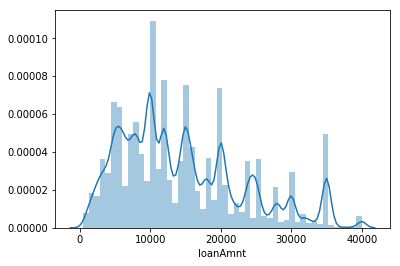

In [94]:
sns.distplot(data_train['loanAmnt'])

#### 分位数分箱-不太懂

In [32]:
# 将数据分成4份，每份中的数据个数相同
data_train['loanAmnt_bin3'] = pd.qcut(data_train['loanAmnt'],10,labels=False)

In [109]:
pd.qcut(range(5), 4, labels=False)

array([0, 0, 1, 2, 3], dtype=int64)

In [144]:
data_train['employmentTitle'].nunique()

248683

### 卡方分箱

In [36]:
data_test.shape

(200000, 109)

### 特征的交互

#### 特征和特征之间的组合

#### 特征和特征之间衍生

In [ ]:
for col in ['grade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.set_index('grade',inplace=True)
#     temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()
    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test[col + '_target_mean'] = data_test[col].map(temp_dict)

#### 其它特征衍生的尝试

In [115]:
# 其他衍生变量 mean 和 std,按照grade分组，计算每个组内，n0,n1,....,n14的均值和标准差
fea = np.array(['n0', 'n1','n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14'])
for df in [data_train, data_test]:
    for item in ['n0']:
        df['grade_to_mean_' + item] = df[item] / df.groupby('grade')[item].transform('mean')
        df['grade_to_std_' + item] = df[item] / df.groupby('grade')[item].transform('std')

### 特征编码
- one-hot编码
- label-encode编码

In [84]:
data_train[['employmentTitle', 'postCode', 'title']][:5]

,employmentTitle,postCode,title
0,192025,43,1
1,104733,64,6326
2,189509,265,0
3,249631,55,26200
4,256267,226,910


In [83]:
data_train[['employmentTitle', 'postCode', 'title']].nunique()

employmentTitle    248683
postCode              932
title               39644
dtype: int64

In [33]:
for col in tqdm(['employmentTitle', 'postCode', 'title']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test[col] = le.transform(list(data_test[col].astype(str).values))
print('Label Encoding 完成')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]

Label Encoding 完成


### 逻辑回归等模型要单独增加的特征工程
- 对特征做归一化，去除相关性高的特征
- 归一化的目的是让训练过程更好更快的收敛，避免特征大吃小的问题
- 去除相关性是增加模型的可解释性，加快预测过程

In [85]:
# 举例归一化过程
#伪代码
for fea in [要归一化的特征列表]：
    data[fea] = ((data[fea] - np.min(data[fea])) / (np.max(data[fea]) - np.min(data[fea])))

SyntaxError: invalid character in identifier (<ipython-input-85-fa43f959a4d9>, line 3)

### 特征选择

特征选择技术可以精简掉无用的特征，以降低最终模型的复杂性，它的最终目的是得到一个简约模型，在不降低预测准确率或对预测准确率影响不大的情况下提高计算速度。特征选择不是为了减少训练时间（实际上，一些技术会增加总体训练时间），而是为了减少模型评分时间。
1. Filter
- 方差选择法
- 相关系数法（pearson相关系数）
- 卡方检验
- 互信息法
2. Wrapper(RFE)
- 递归特征消除法
3. Embedded
- 基于惩罚项的特征选择法
- 基于树模型的特征选择

#### Filter-方差选择法

In [105]:
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值

selector = VarianceThreshold(threshold=4)
selector.fit_transform(data_train[fea]).shape

(800000, 10)

In [120]:
# 方差大于阈值的特征
fea[selector.variances_>selector.threshold]

array(['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10'],
      dtype='<U3')

方差选择法-练习

In [96]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 2, 0], [9, 1, 4], [0, 1, 6]]
print(X)
selector = VarianceThreshold(threshold=2)
selector.fit_transform(X)


[[0, 2, 0], [9, 1, 4], [0, 1, 6]]


array([[0, 0],
       [9, 4],
       [0, 6]])

In [98]:
print(X)

[[0, 2, 0], [9, 1, 4], [0, 1, 6]]


fit表示只从数据中学习方差，但是并不会应用
但是,fit_transform不止会学习方差，还会应用在数据上，完成了两个操作

In [97]:
# 通过variances_属性查看样本各个特征的方差
print(selector.variances_)

[18.          0.22222222  6.22222222]


参考链接：https://blog.csdn.net/kancy110/article/details/72835050

### 卡方检验

经典的卡方检验是用于检验自变量对因变量的相关性，假设自变量有N种取值，因变量有M种取值，考虑自变量等于i且因变量等于j的样本频数的观察值与期望的差距。其统计量如下

注意：卡方只能用在正定矩阵上，否则会报错Input X must be non-negative)

In [204]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#参数k为选择的特征个数,评分最高的5个特征

selector_kf = SelectKBest(chi2, k=5)
selector_kf.fit_transform(data_train[fea],data_train['isDefault'])[:10]

array([[ 2.,  2.,  4.,  2.,  2.],
       [ 2.,  2.,  4.,  2.,  2.],
       [ 3.,  3.,  4.,  3.,  4.],
       [ 6.,  6.,  7.,  6.,  1.],
       [ 7.,  7., 10.,  7.,  4.],
       [ 2.,  2.,  2.,  2.,  0.],
       [ 3.,  3., 10.,  3.,  3.],
       [ 4.,  4.,  5.,  4.,  2.],
       [13., 13., 13., 11.,  6.],
       [ 5.,  5.,  6.,  5.,  8.]])

In [195]:
# 特征得分，得分越高表示，表示该特征越好
s = selector_kf.scores_
fea[np.argpartition(s,-5)[-5:]]

array(['n7', 'n9', 'n3', 'n2', 'n14'], dtype='<U3')

In [196]:
# p值越小，置信度越高，特征并不是按照这个排序的
p=selector_kf.pvalues_
fea[np.argpartition(p,-5)[-5:]]

array(['n0', 'n8', 'n4', 'n13', 'n6'], dtype='<U3')

#### argpartition的使用

参考链接：
- https://blog.csdn.net/snowdroptulip/article/details/78867053
- https://www.pythonheidong.com/blog/article/327681/

In [192]:
z = np.array([1,4,3,0, 2, 5])
print(z)
print(z[np.argpartition(z,2)])

[1 4 3 0 2 5]
[0 1 2 4 3 5]


In [162]:
a = np.array([9, 5.5, 2, 3, 7, 11, 0, 4.9, 6, 0])

In [172]:
# kth = [1,2]，找到对第1,2大的数（两个数之间会进行排序），比它小的数放到它前边，并进行排序；比它大的数放到它后边，但并不会进行排序，保持原顺序。
ind = np.argpartition(a, [3,6])
a[ind]

array([ 0. ,  0. ,  2. ,  3. ,  4.9,  5.5,  6. ,  7. , 11. ,  9. ])

#### embedded

计算协方差，可是，协方差有什么用

In [207]:
# 删除不需要的数据
for data in [data_train, data_test]:
    data.drop(['issueDate','id'], axis=1,inplace=True)

In [217]:
fea=np.append(fea,np.array(['isDefault']))

In [218]:
x_train = data_train[fea].drop(['isDefault'], axis=1)
# 计算协方差
data_corr = x_train.corrwith(data_train[fea].isDefault) # 计算相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

#### 用热图查看

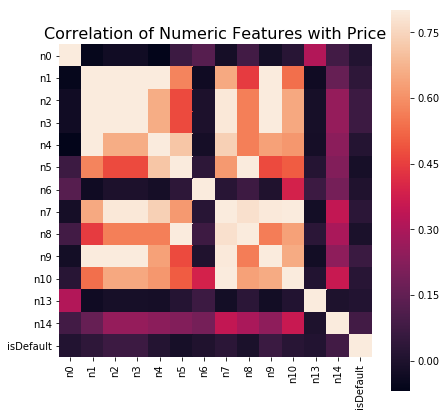

In [221]:
# 当然也可以直接看图
data_numeric = data_train[fea[:-1]]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

### 构建模型

In [222]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [223]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

In [226]:
y_train = data_train.isDefault

In [228]:
# x_train = data_train
data_train.shape

(800000, 115)

In [229]:
data_test.shape

(200000, 110)

In [227]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

NameError: name 'x_test' is not defined